In [1]:
import sys
import os
import numpy as np
import pandas as pd
from glob import glob
from scipy.signal import ricker
from scipy.optimize import minimize

In [2]:
sys.path.append('../../../repos/seismiqb/')
from seismiqb import Well, WellSeismicMatcher, show_wavelet, symmetric_wavelet_estimation
from seismiqb import plot, Field

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

## Open and filter log

* select the well and create a `WellMatcher`-instance

In [4]:
cube_path = '/data/seismic_data/seismic_interpretation/105_ZAPZIP/105_ZAPZIM_CLEANED.sgy'
coordinates_path = '/data/seismic_data/seismic_interpretation/105_ZAPZIP/Well/Coordinates/Coordinates_wells.txt'

well_paths_mask = '/data/seismic_data/seismic_interpretation/105_ZAPZIP/Well/LAS/*'
well_paths = sorted(glob(well_paths_mask))

well_number = 3
well_path = well_paths[well_number]

In [5]:
matcher = WellSeismicMatcher(wavelet=4 * ricker(60, 4.3))
matcher.from_paths(cube_path, coordinates_path, well_path)
matcher.process_logs()

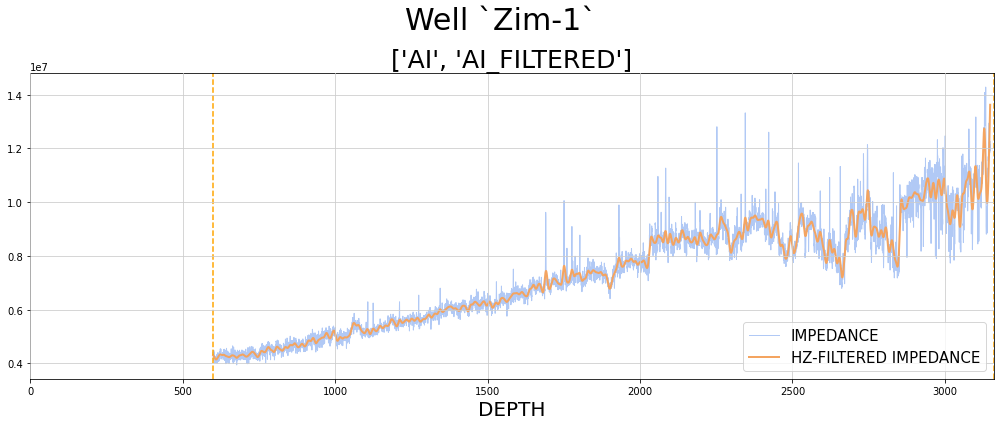

In [6]:
matcher.plot_well(logs=['AI', 'AI_FILTERED'], combine='overlay', window=None, figsize=(14, 6),
                  curve_alpha=[.5, 1], curve_linewidth=[1, 2], label=['IMPEDANCE', 'HZ-FILTERED IMPEDANCE'])

* cast filtered log into seismic time, generate synthetic out of it and compare with original seismic

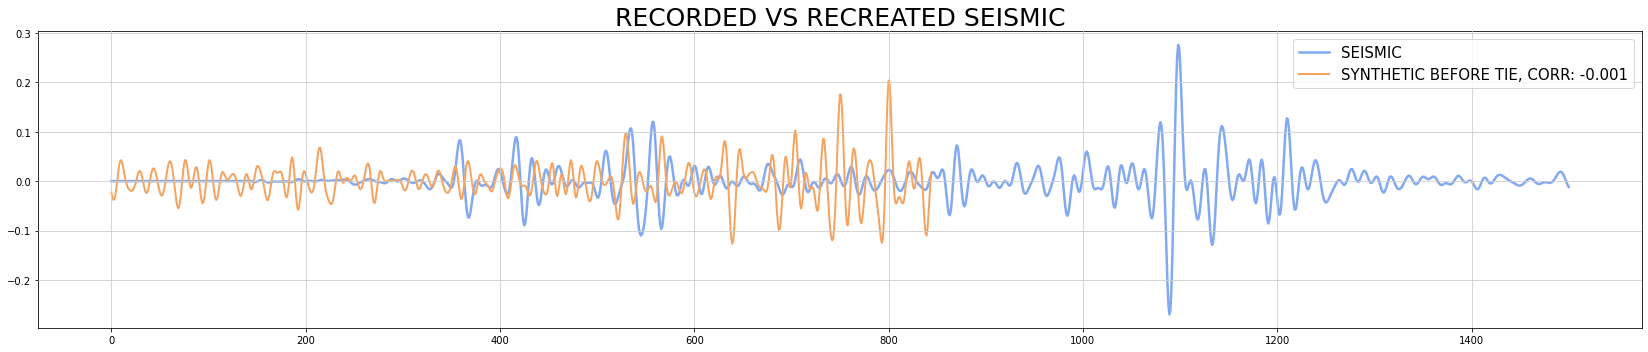

In [7]:
# Show starting tie quality
matcher.show_tie_comparison(src_well_time='well_time', src_wavelet='wavelet',
                            curve_color=['cornflowerblue', 'sandybrown'], curve_linestyle=['solid', 'solid'])

In [8]:
# We can clearly see that there exists an unknown shift that we need to determine
# Let's make it happen by improving the wavelet estimation and the looking at crocccorrelation plot

## Symmetric wavelet estimation

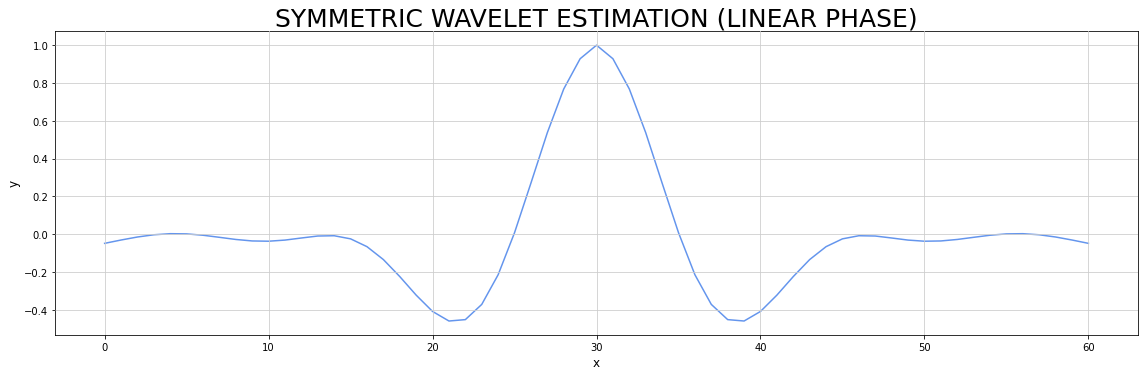

In [9]:
wavelet_0 = symmetric_wavelet_estimation(matcher.seismic_curve, wavelet_length=61)
plot(wavelet_0, mode='curve', title='SYMMETRIC WAVELET ESTIMATION (LINEAR PHASE)')

## Finding best shift

* Check out initial ranges of well time and seismic time to determine limits for shift

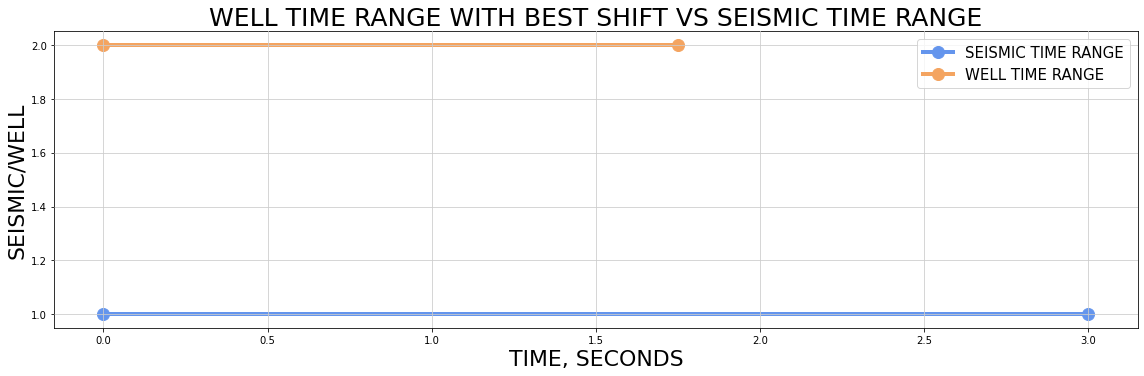

In [10]:
matcher.show_ranges()

In [11]:
matcher.wavelet = wavelet_0
matcher.compute_tie_crosscorrelation(limits=(-.5, 1.5))

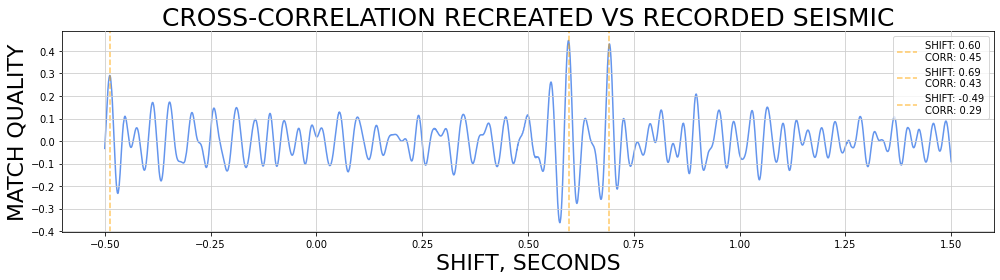

In [12]:
matcher.show_tie_crocccorrelation(n_peaks=3)

In [13]:
matcher.tie_crosscorrelation['peak_shifts'][:3]

[0.5957095709570956, 0.6923192319231923, -0.4881988198819882]

* determine the best shift starting from a chosen point

In [14]:
# Note here that we took the second best option - because of visual preference
matcher.optimize_shift(.69)

array([0.69234393])

In [15]:
best_shift = 0.69234393

In [16]:
matcher.shifted_well_time = matcher.well_time + best_shift

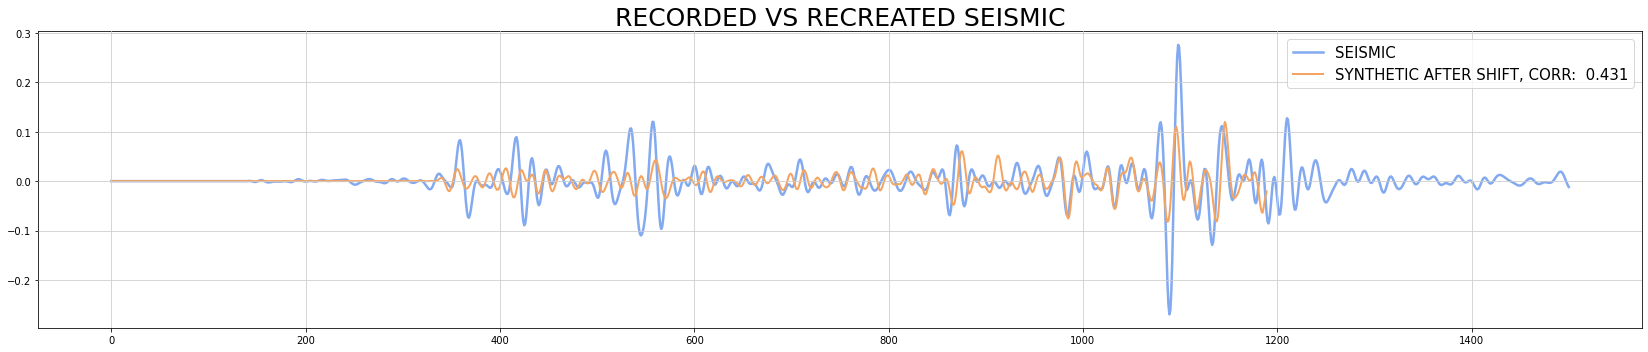

In [17]:
# Visually control the chosen shift
matcher.show_tie_comparison(src_well_time='shifted_well_time', src_wavelet='wavelet',
                            curve_color=['cornflowerblue', 'sandybrown'], curve_linestyle=['solid', 'solid'],
                            synthetic_postfix='AFTER SHIFT')

In [18]:
matcher.add_shift(shift=best_shift)

## Improve well-seismic tie (1) - optimize DTs to improve match

In [19]:
# Setting limits for scaling of deltas during optimization
bounds_multipliers = [0.96, 1.04]

In [20]:
# Select valid seismic time-slice [time-ticks where we can interpolate values of impedance-log]
clean_time_slice = matcher.get_relevant_seismic_slice(matcher.seismic_time, matcher.well_time, matcher.impedance_log)

In [21]:
# Run the optimization procedure to optimize ticks
# Select only the subset of seismic ticks - those we can recompute the synthetic in
results = matcher.optimize_well_time(dst_history='well_time_initial', seismic_time_slice=clean_time_slice, dt_bounds_multipliers=bounds_multipliers,
                                     n_iters=10000, optimizer='SGD', optimizer_kwargs={'lr': 5e-9})

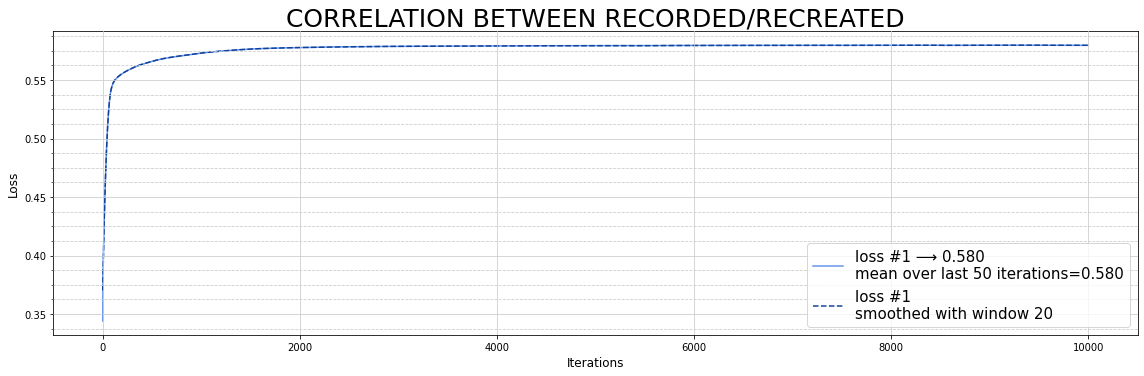

In [23]:
plot(-np.array(results[-1]),  mode='loss', title='CORRELATION BETWEEN RECORDED/RECREATED')

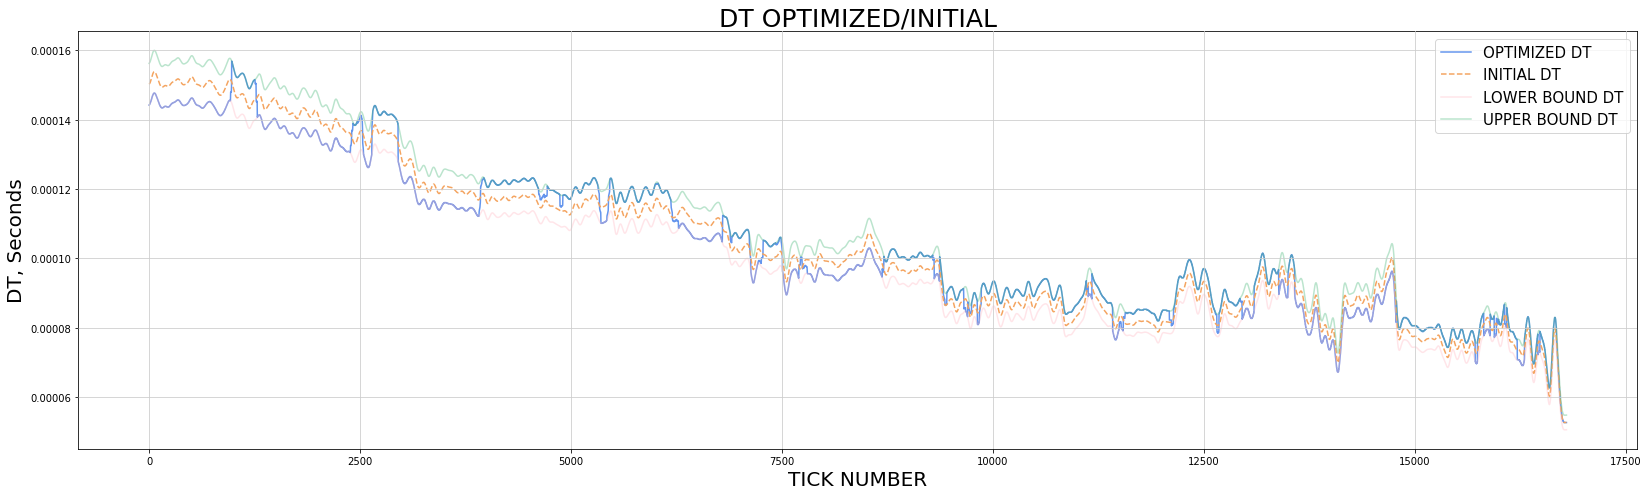

In [24]:
matcher.show_dt(bounds_multipliers=bounds_multipliers)

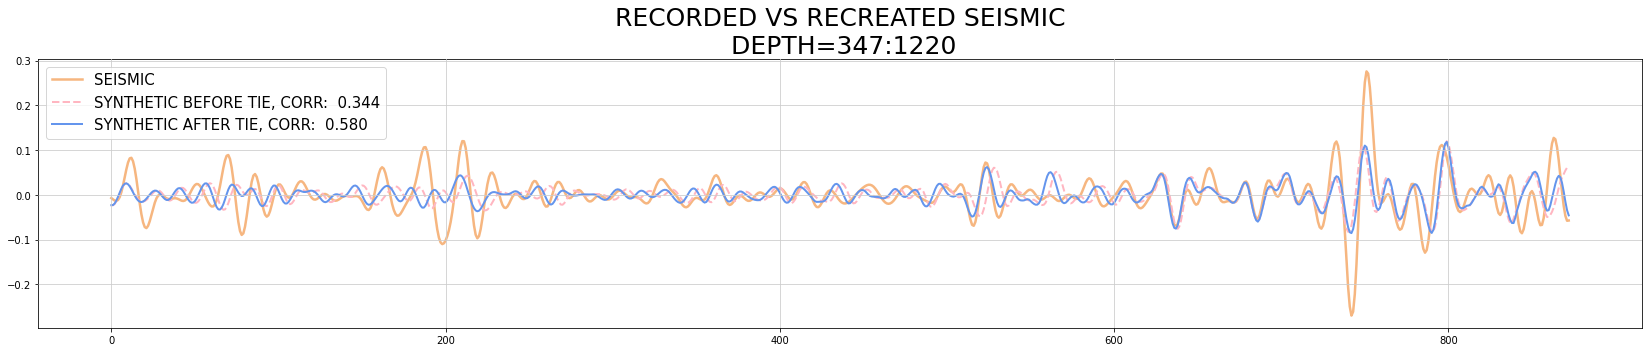

In [25]:
matcher.show_tie_comparison(src_well_time=('well_time_initial', 'well_time'), seismic_time_slice=clean_time_slice)

## Improve the wavelet (1)

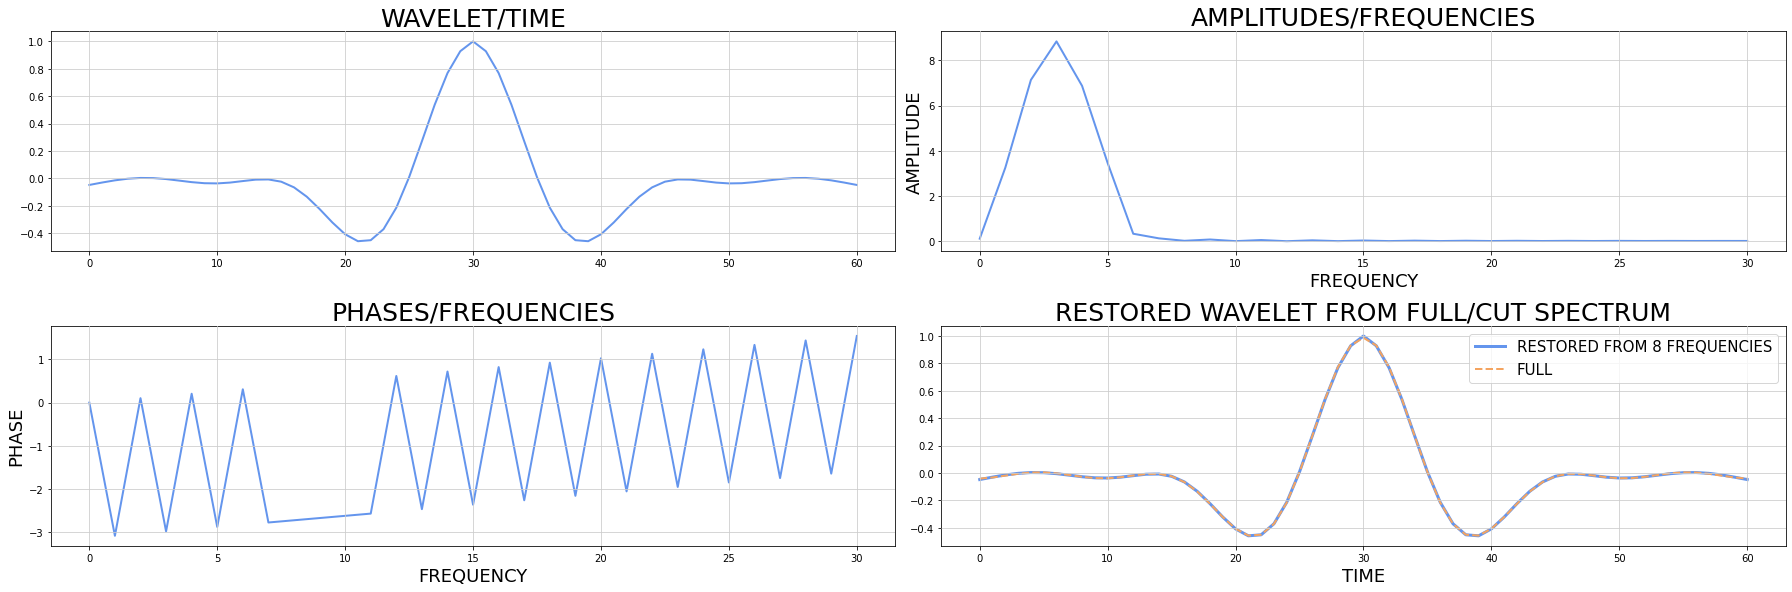

In [26]:
show_wavelet(matcher.wavelet)
# Use this plot to determine the allowed bounds for phases-optimization
# as well as the number of meaningful frequencies.
# If the wavelet can be reconstructed from, say, 7 frequencies - the rest of them can be safely ignored.

In [27]:
matcher.measure_tie_quality()

0.6536090473658248

In [28]:
# select the parameters
cut_frequency = 8
delta=.9

In [29]:
_ = matcher.optimize_wavelet(dst_history='wavelet_0', seismic_time_slice=clean_time_slice, cut_frequency=cut_frequency,
                             delta=delta)

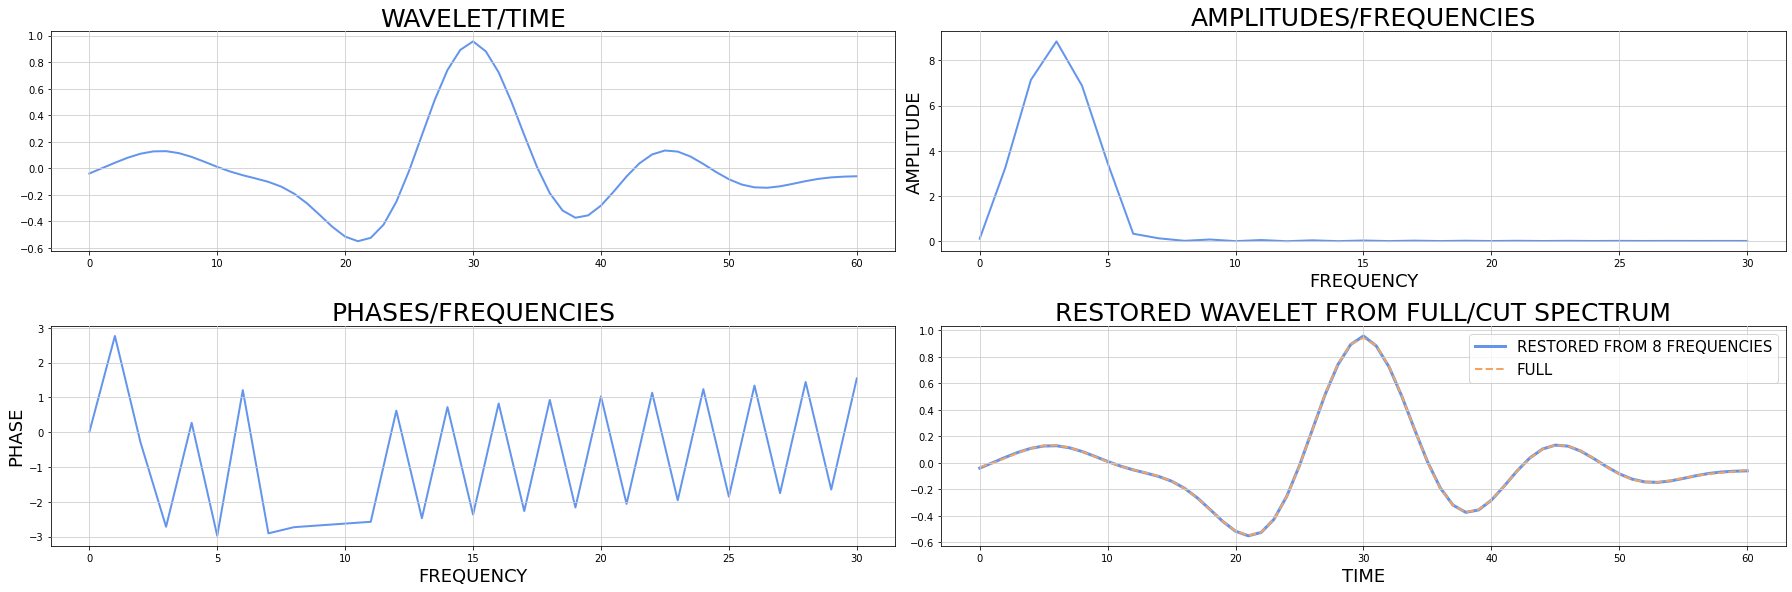

In [30]:
show_wavelet(matcher.wavelet)

In [31]:
matcher.measure_tie_quality()

0.6572359549730709

## Run several more iterations of [well_tie + wavelet-optimization]

In [32]:
# Parameters of the procedure.
N_ITERS = 3
bounds_multipliers = [0.96, 1.04]
cut_frequency = 8
delta = .9

for _ in range(N_ITERS):
    # Optimize well-time ticks
    _, loss_history = matcher.optimize_well_time(seismic_time_slice=clean_time_slice,
                                                 dt_bounds_multipliers=bounds_multipliers,
                                                 n_iters=10000, optimizer='SGD',
                                                 optimizer_kwargs={'lr': 5e-9})

    # Optimize and update wavelet
    _ = matcher.optimize_wavelet(cut_frequency=cut_frequency, delta=delta)

    # Just for info
    print(matcher.measure_tie_quality())

0.7395282682737477
0.783532065770118
0.8169989267019637


* check out the final results: the optimized ticks and the wavelet

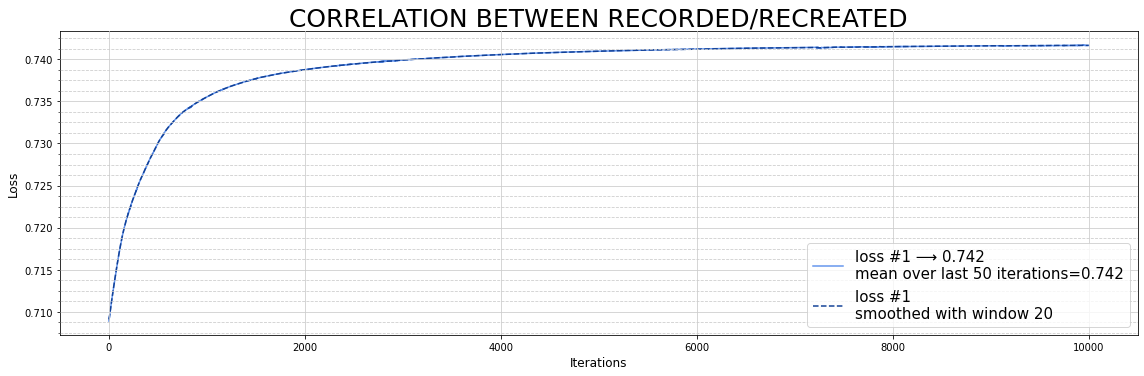

In [33]:
plot(-np.array(loss_history),  mode='loss', title='CORRELATION BETWEEN RECORDED/RECREATED')

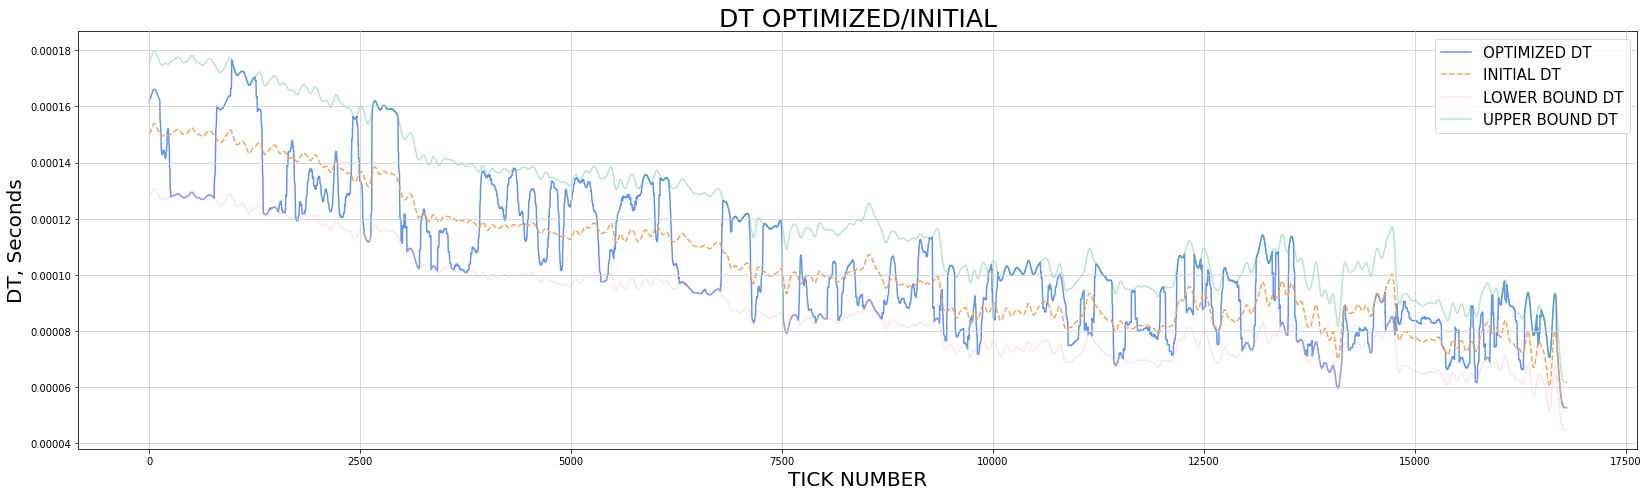

In [34]:
matcher.show_dt(bounds_multipliers=(.96**4, 1.04**4))

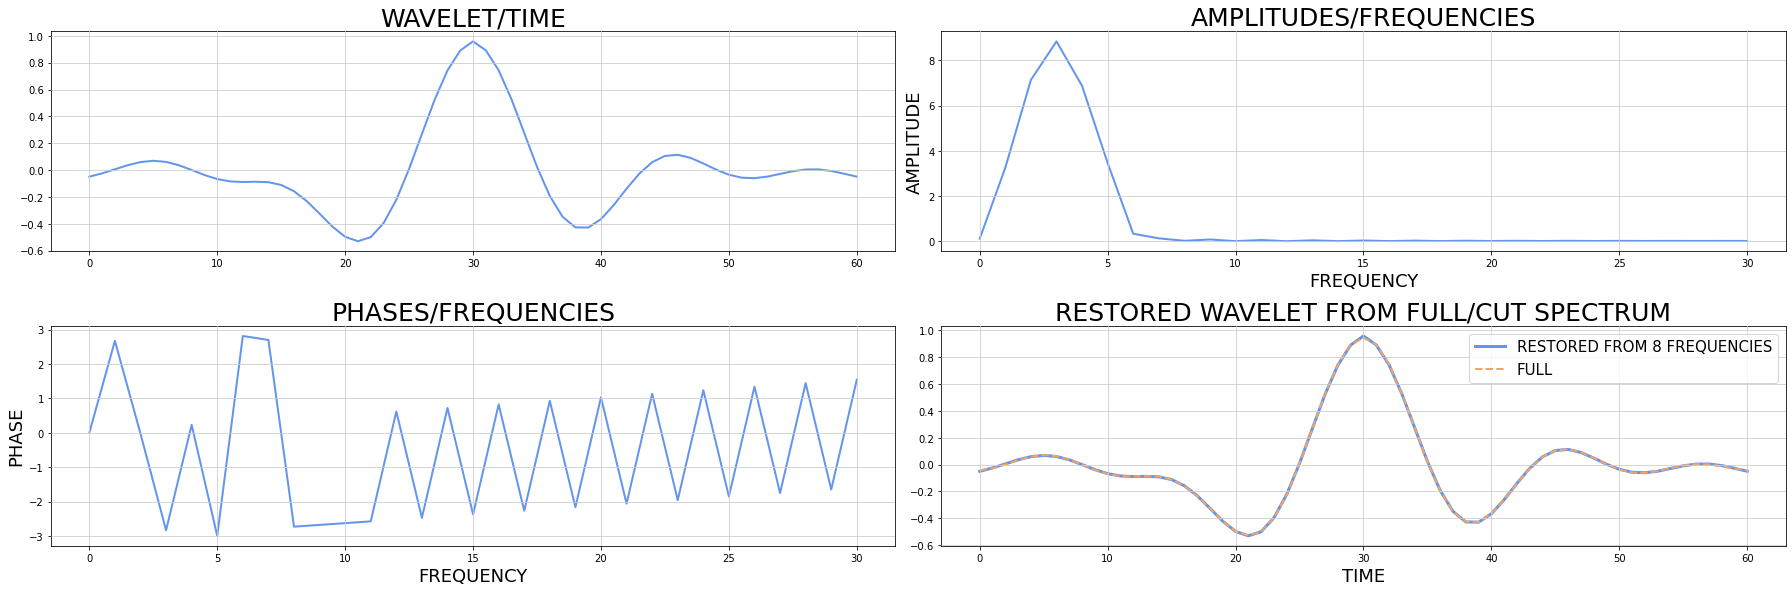

In [35]:
show_wavelet(matcher.wavelet)

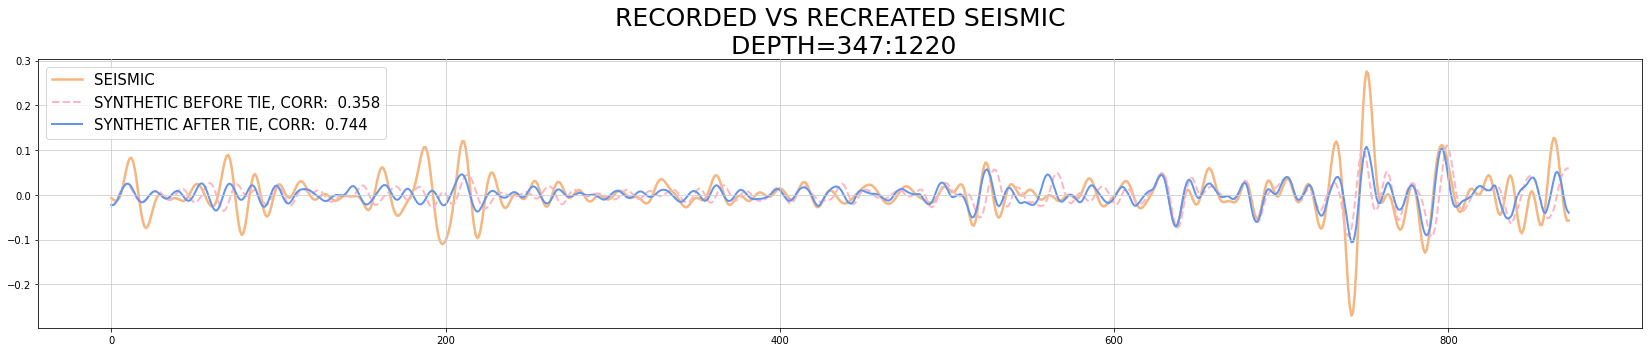

In [36]:
matcher.show_tie_comparison(seismic_time_slice=clean_time_slice)

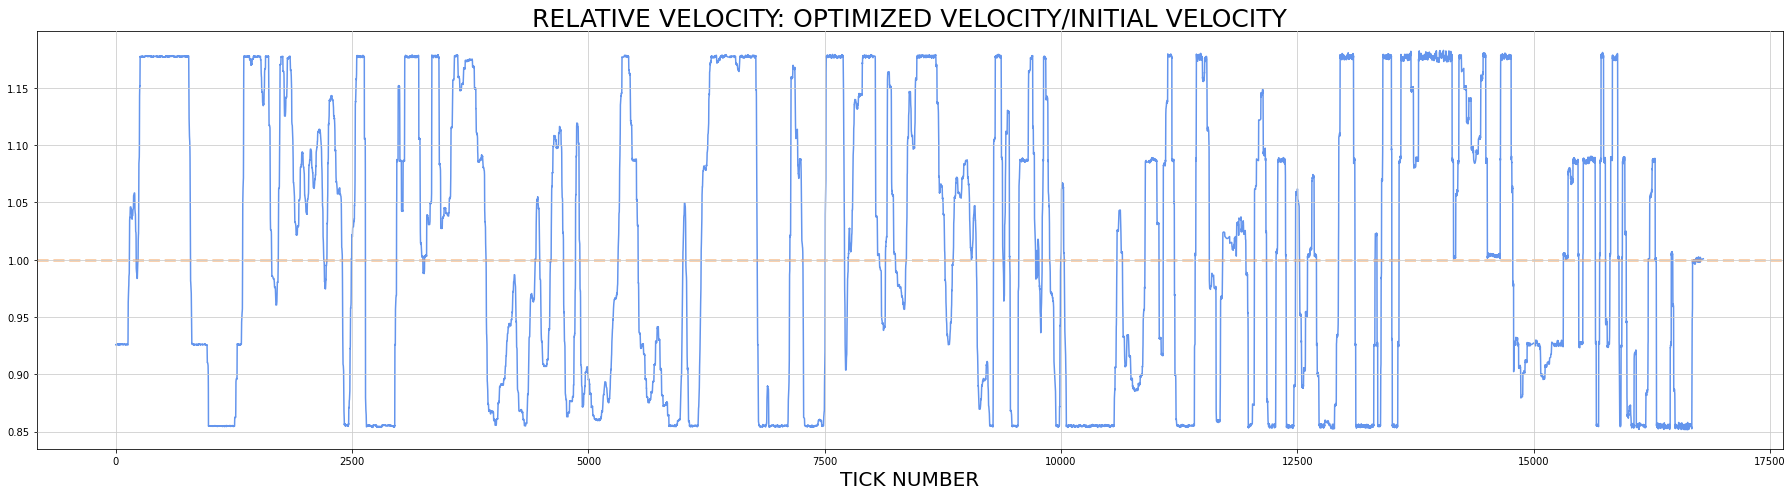

In [37]:
plotter = matcher.show_relative_velocities()
# plotter.save(savepath='./_DUMP/relative_velocity.png')

## Dump

* synthetic

In [ ]:
synthetic = matcher.resample_and_compute_synthetic(matcher.seismic_time, matcher.well_time, matcher.impedance_log,
                                                   matcher.wavelet)
synthetic = np.nan_to_num(synthetic)
synthetic = synthetic.reshape(1, 1, -1)

In [ ]:
from seismiqb import array_to_segy

In [ ]:
field = Field(cube_path)

In [ ]:
spec = field.geometry.make_export_spec(synthetic, origin=(512, 548, 0))

In [ ]:
array_to_segy(synthetic, './_DUMP/synthetic_trace.segy', spec=spec)

* wavelet

In [ ]:
df_wavelet = pd.DataFrame(data=np.array([np.arange(len(matcher.wavelet)) * ff.geometry.sample_interval*1e-3,
                                         matcher.wavelet]).T,
                          columns=['TIME', 'VALUE'])

In [ ]:
df_wavelet.to_csv('./_DUMP/zim_1_impulse_v3.txt', header=True, index=False, sep=' ')

* well_time

In [ ]:
df_well_time = pd.DataFrame(data=np.array([matcher.well.index.values, matcher.well_time * 1e3]).T,
                            columns=['DEPT', 'TIME'])

In [ ]:
df_well_time.to_csv('./_DUMP/zim_1_depth_time_v3.txt', header=True, index=False, sep=' ')

* lasfile

In [ ]:
import lasio

In [ ]:
las = lasio.read(well_path)

In [ ]:
# plot([matcher.well.DT.values, matcher.well.DT_FILTERED.values], mode='curve')
# plot([matcher.well.RHOB.values, matcher.well.RHOB_FILTERED.values], mode='curve')
# plot([matcher.well.AI.values, matcher.well.AI_FILTERED.values], mode='curve')

In [ ]:
# Put filtered curves into the las
las.append_curve('AI_FILTERED', matcher.well.AI_FILTERED.values, unit='kPa.s/m', descr='AI_FILTERED')
las.append_curve('DT_FILTERED', matcher.well.DT_FILTERED.values, unit='us/ft', descr='DT_FILTERED')
las.append_curve('RHOB_FILTERED', matcher.well.RHOB_FILTERED.values, unit='g/cm3', descr='RHOB_FILTERED')

In [ ]:
# Write las
with open('./_DUMP/with_filtered.las', mode='w') as file:
    las.write(file, version=2.0)